In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import sys; sys.path.append('../')
from misc import h5file
from itertools import combinations
from pathlib import Path

import numpy as np
import jax.numpy as jnp
from numpy.random import default_rng
import scipy.io as sio
from scipy.optimize import curve_fit
from jaxfit import CurveFit
from levenberg_marquardt import lm as lm_curve_fit
from statsmodels.api import OLS as SMOLS
import sympy
import pandas as pd

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from siren_pytorch import SirenNet

import pysindy as ps

from sympy import symbols, sympify, simplify, lambdify
from mathparser import math_eval
from varname import nameof

import sys; sys.path.append('../optimizers/')
from Adan import Adan

import sys; sys.path.append('../../parametric-discovery/')
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise
from functools import partial
from best_subset import composite_function, ps_features
import derivative

def percent_coeff_error(pred):
    ground = np.array([0.1, -1])
    errs = 100*np.abs(np.array(pred)-ground)/np.abs(ground)
    return errs.mean(), errs.std()

MAIN_SEED = 1234

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
class KalmanDiff(ps.BaseDifferentiation):
    def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
        super(KalmanDiff, self).__init__()
        # Kalman diff
        self.alpha = alpha
        self.diff_func = derivative.Kalman(alpha=self.alpha)
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        # Savgol denoising
        self.poly_deg = poly_deg
        if poly_deg is not None:
            if poly_deg%2 == 0: window_length = self.poly_deg + 1
            else: window_length = self.poly_deg + 2
            self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
        else:
            self.denoise = lambda _: _
        # Robust PCA
        self.rpca_lambda = rpca_lambda
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        # data transformation
        # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
        self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
    # _differentiate
    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
                #                   for j in range(x.shape[1])])
                # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
                diff = self.transform(x[:,:,i].T, t).T
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
                #                   for j in range(x.shape[0])])
                # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
                diff = self.transform(x[:,:,i], t)
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)
    # _get_low_rank
    def _get_low_rank(self, x):
        rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
        rpca.fit(x)
        return rpca.get_low_rank()

In [3]:
noise_lv = 30
denoising_mode = 'ksvd'
smoother_name = 'filterpy'
n_components = 32
transform_n_nonzero = '_none'
undenoised = False

fp1 = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_pms_noise30_dictlearn{n_components}.h5"
fp2 = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_pms_feature_names_noise30_dictlearn{n_components}.yaml"

fp1, fp2

('../PMS_data/ksvd/filterpy/transform_n_nonzero_coefs_none/burgers_pms_noise30_dictlearn32.h5',
 '../PMS_data/ksvd/filterpy/transform_n_nonzero_coefs_none/burgers_pms_feature_names_noise30_dictlearn32.yaml')

In [4]:
# RDAE, noRDAE
X_pre, avg_weak_coeff, best_subsets, un, y_pre = \
h5file(file_path=fp1, mode='r', return_dict=False)

['X_pre', 'avg_weak_coeff', 'best_subsets', 'un', 'y_pre']


In [5]:
import yaml
# RDAE, noRDAE
with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]
encoded_pde_names

['u*u_1',
 'u_11+u*u_1',
 'u_11+u*u_1+u*u*u_1',
 'u*u+u_11+u*u_1+u*u_11',
 'u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11',
 'u+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11',
 'u+u*u+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11']

In [6]:
# [np.linalg.lstsq(X_pre[:, np.where(best_subsets[i]>0)[0]], 
#                  y_pre, rcond=None)[0].flatten() for i in range(len(best_subsets))]

In [7]:
poly_complexities = [name.count('*')+name.count('+')+1 for name in encoded_pde_names]

In [8]:
data = sio.loadmat('../Datasets/burgers.mat')

u_clean = data['usol'].real
x = data['x'][0].real
t = data['t'][:,0].real
dt = t[1]-t[0]; dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

if undenoised:
    np.random.seed(0)
    un = u_clean + 0.01*np.abs(noise_lv)*(u_clean.std())*np.random.randn(u_clean.shape[0], 
                                                                         u_clean.shape[1])
    print("In the Undenoised mode...")
else:
    print("In the Denoised mode...")
    
# del data, u_clean

In the Denoised mode...


In [9]:
def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    nobs2 = nobs / 2.0
    ssr = np.sum(np.abs(ground - prediction)**2)
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

In [10]:
def count_parameters(torch_model, onlyif_requires_grad=True):
    if onlyif_requires_grad:
        return sum(p.numel() for p in torch_model.parameters() if p.requires_grad)
    return sum(p.numel() for p in torch_model.parameters())

In [11]:
class PhysicalConstraintCalculator(nn.Module):
    def __init__(self, symbolic_module, basic_vars, init_coefficients=None, learnable_coefficients=False):
        super(PhysicalConstraintCalculator, self).__init__()
        self.symbolic_module = symbolic_module
        self.basic_vars = basic_vars
        
        self.coefficients = init_coefficients
        self.learnable_coefficients = learnable_coefficients

        if self.coefficients is None:
            self.coefficients = torch.ones(len(symbolic_module.sympy())).float()
        else:
            self.coefficients = torch.tensor(data=self.coefficients).float()
        self.coefficients = nn.Parameter(self.coefficients).requires_grad_(self.learnable_coefficients)
        
        # printing
        if self.learnable_coefficients: print("Learnable coefficients:", self.coefficients)
        else: print("NOT learnable coefficients:", self.coefficients)
        print(symbolic_module.sympy())
        print("Basic variables:", self.basic_vars)

    def set_learnable_coefficients(self, learn):
        self.coefficients.requires_grad_(learn)
    
    def forward(self, input_dict):
        return self.symbolic_module(**input_dict)

In [12]:
class Sine(nn.Module):
    def __init__(self, ):
        super(Sine, self).__init__()
    def forward(self, x):
        return torch.sin(x)

class TorchMLP(nn.Module):
    def __init__(self, dimensions, bias=True, activation_function=nn.Tanh(), bn=None, dropout=None):
        super(TorchMLP, self).__init__()
        # setup ModuleList
        self.model  = nn.ModuleList()
        for i in range(len(dimensions)-1):
            self.model.append(nn.Linear(dimensions[i], dimensions[i+1], bias=bias))
            if bn is not None and i!=len(dimensions)-2:
                self.model.append(bn(dimensions[i+1]))
                if dropout is not None:
                    self.model.append(dropout)
            if i==len(dimensions)-2: break
            self.model.append(activation_function)
        # weight init
        self.model.apply(self.xavier_init)

    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)

    def forward(self, x):
        for i, l in enumerate(self.model): 
            x = l(x)
        return x

In [13]:
class PINN(nn.Module):
    def __init__(self, solver, physics_calculator, lb, ub, 
                 domain_dimension=None, weak_pde_lib=None, effective_indices=None, 
                 ic_module=None):
        super(PINN, self).__init__()
        self.solver = solver
        self.physics_calculator = physics_calculator
        self.lb = lb
        self.ub = ub
        # Only to use weak_loss
        # spatial x temporal
        self.domain_dimension = domain_dimension
        self.weak_pde_lib = weak_pde_lib
        self.effective_indices = effective_indices
        self.weak_coeff_buffer = None
        # must not be None if X_train_initial is not None but y_train_initial is None
        self.ic_module = ic_module
        
    def forward(self, x, t):
        return self.solver(self.input_normalize(torch.cat([x, t],  dim=-1)))

    def calculate_physics(self, x, t):
        u = self.forward(x, t)
        u_t = self.gradients(u, t)[0]
        u_1 = self.gradients(u, x)[0]
        u_11 = self.gradients(u_1, x)[0]
        physics = self.physics_calculator({nameof(u):u, 
                                           nameof(u_1):u_1, 
                                           nameof(u_11):u_11})
        
        return u, u_t, physics
    
    def loss(self, x, t, y_input, X_train_initial=None, y_train_initial=None):
        u, u_t, physics = self.calculate_physics(x, t)
        coeff = self.physics_calculator.coefficients
        physics = (physics*coeff).sum(axis=-1)
        mse = F.mse_loss(u, y_input, reduction='mean')
        
        # initial condition (ic)
        if X_train_initial is not None:
            ic_u_pred = self.solver(self.input_normalize(X_train_initial))
            if y_train_initial is None:
                y_train_initial = self.ic_module(X_train_initial)
            ic_loss = F.mse_loss(ic_u_pred, y_train_initial, reduction='mean')
            mse = torch.add(mse, ic_loss)
            
        l_eq = F.mse_loss(u_t, physics, reduction='mean')
        return mse, l_eq
    
    def weak_loss(self, x, t, y_input):
        u, u_t, physics = self.calculate_physics(x, t)
        coeff = torch.tensor(self.weak_coefficients(u)).float()
        physics = (physics*coeff).sum(axis=-1)
        mse = F.mse_loss(u, y_input, reduction='mean')
        
        # initial condition (ic)
        if X_train_initial is not None:
            ic_u_pred = self.solver(self.input_normalize(X_train_initial))
            if y_train_initial is None:
                y_train_initial = self.ic_module(X_train_initial)
            ic_loss = F.mse_loss(ic_u_pred, y_train_initial, reduction='mean')
            mse = torch.add(mse, ic_loss)
            
        l_eq = F.mse_loss(u_t, physics, reduction='mean')
        return mse, l_eq
    
    def weak_form(self, u):
        pred = u.reshape(self.domain_dimension[1], 
                         self.domain_dimension[0]).T.detach().numpy()
        pred = np.expand_dims(pred,-1)
        X_weak = self.weak_pde_lib.fit_transform(pred)
        y_weak = self.weak_pde_lib.convert_u_dot_integral(pred)
        return X_weak, y_weak
    
    def weak_coefficients(self, u):
        np.random.seed(0)
        X_weak, y_weak = self.weak_form(u)
        X_weak = X_weak[:, self.effective_indices]
        self.weak_coeff_buffer = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0].flatten()
        return self.weak_coeff_buffer
    
    def set_learnable_ic(self, flag):
        self.ic_module.requires_grad_(flag)
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, 
                    grad_outputs=torch.ones(func.shape))

    def input_normalize(self, inp):
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [14]:
rng = default_rng(seed=0)
mode = 'finetuning' # 'selection', finetuning'
if mode == 'finetuning':
    sampled_indices_x = np.array([i for i in range(len(x)) if i%2==0])
    sampled_indices_t = np.array([i for i in range(len(t)) if i%2==0])
elif mode == 'selection':
    sampled_indices_x = np.array([i for i in range(len(x)) if i<len(x)//2+1])
#     sampled_indices_t = np.array([i for i in range(len(t)) if i<len(t)//2+1 and i!=0])
    sampled_indices_t = np.array([i for i in range(len(t)) if i<len(t)//2+1])
print(mode)
domain_dimension = len(sampled_indices_x), len(sampled_indices_t)

finetuning


In [15]:
np.random.seed(MAIN_SEED);
torch.manual_seed(MAIN_SEED);

In [16]:
XX = X[sampled_indices_t, :][:, sampled_indices_x]
TT = T[sampled_indices_t, :][:, sampled_indices_x]
XXTT = XT[sampled_indices_x, :, :][:, sampled_indices_t, :]

In [17]:
# kalpha = 1e-1; poly_deg = None
# differentiation_method = KalmanDiff
# differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}

# weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x:x, lambda x: x*x], 
#                                  function_names=[lambda x:x, lambda x: x+x], 
#                                  derivative_order=diff_order, p=diff_order, 
#                                  spatiotemporal_grid=XXTT, 
#                                  include_bias=False, is_uniform=True, K=K, # new random K points in every calls to the ps.WeakPDELibrary
#                                  differentiation_method=differentiation_method, 
#                                  differentiation_kwargs=differentiation_kwargs, 
#                                  cache=False
#                                 )

K = 3000; diff_order = 2
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x:x, lambda x: x*x], 
                                 function_names=[lambda x:x, lambda x: x+x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XXTT, 
                                 include_bias=False, is_uniform=True, K=K # new random K points in every calls to the ps.WeakPDELibrary
                                )

In [18]:
X_train = np.hstack((XX.flatten()[:,None], TT.flatten()[:,None]))
y_train = un.T[sampled_indices_t, :][:, sampled_indices_x].flatten()[:,None]
# lb = torch.tensor([x.min(), t.min()]).float().requires_grad_(False)
# ub = torch.tensor([x.max(), t.max()]).float().requires_grad_(False)
lb = torch.tensor(X_train.min(axis=0)).float().requires_grad_(False)
ub = torch.tensor(X_train.max(axis=0)).float().requires_grad_(False)

In [19]:
del XX, TT, XXTT

In [20]:
# Actually this eq is valid for smoother_name = 'kalman' only but anyways...
hof = pd.read_csv("./hof.csv")
if smoother_name != 'none': 
    hof = pd.read_csv(f"./hof_{smoother_name}.csv")
equation = hof.iloc[np.argmax(hof["score"])]
# how to extract float numbers from a sympy object?
print(equation.equation)

exp(-1.0224758 * square(2.0148342 + x0))


In [21]:
func = lambdify(args=sympy.symbols('x0'), expr=equation.equation)
pysr_params = np.array(sorted([float(atom) for atom in sympify(equation.equation).atoms() if atom.is_number]))
initial_indices = np.where(X_train[:, 1:2]==0.0)[0]

In [22]:
def initial_function(x, a, b): return np.exp(a*np.square(x+b))
def jax_initial_function(x, a, b): return jnp.exp(a*jnp.square(x+b))

recovered_params1 = np.array(CurveFit().curve_fit(jax_initial_function, x.flatten(), un[:, 0], 
                                                  p0=np.round(pysr_params))[0]) # p0=np.round(pysr_params), p0=None

recovered_params2 = np.array(curve_fit(initial_function, x.flatten(), un[:, 0], 
                                       p0=None, method='lm')[0])

recovered_params3 = lm_curve_fit(np.round(pysr_params).reshape(-1, 1), 
                                 x.flatten(), un[:, 0], 
                                 lambda t,p: np.exp(p[0,0]*np.square(t+p[1,0])))[0].flatten()

# pysr_params, recovered_params1, recovered_params2, recovered_params3 (recommended when finetuning)
recovered_params = recovered_params3
# recovered_params = np.round(recovered_params, decimals=6)
print(recovered_params)

initial_function = partial(initial_function, a=recovered_params[0], b=recovered_params[1])
# initial_function = partial(initial_function, a=-1.0, b=2.0) # GROUND
# initial_function = func

2023-05-03 19:46:44,309 [INFO] Remote TPU is not linked into jax; skipping remote TPU.
2023-05-03 19:46:44,310 [INFO] Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
2023-05-03 19:46:44,310 [INFO] Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-03 19:46:44,311 [INFO] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-03 19:46:44,312 [INFO] Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-05-03 19:46:44,312 [INFO] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


Using uniform weights for error analysis
**** Convergence in r.h.s. ("JtWdy")  ****

LM fitting results:
----------------------------- 
parameter      = p1
fitted value   = -1.0223
standard error = -2.45 %
----------------------------- 
parameter      = p2
fitted value   = 2.0148
standard error = 1.24 %
[-1.02228658  2.01481567]


In [23]:
X_train_initial, y_train_initial = None, None
add_initial_data = 2 # 0, 1, 2

X0, T0 = np.meshgrid(x, np.array([0.0]))

if add_initial_data == 1:
    ### V1 of adding initial data ###
    if len(initial_indices) > 0:
        y_train[initial_indices] = np.vectorize(initial_function)(X_train[initial_indices][:, 0:1])
elif add_initial_data == 2:
    ### V2 of adding initial data ###
    if add_initial_data:
        X_train_initial = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))
        y_train_initial = initial_function(X_train_initial[:, 0:1])
        X_train_initial = torch.tensor(X_train_initial).float().requires_grad_(False)
        y_train_initial = torch.tensor(y_train_initial).float().requires_grad_(False)

if add_initial_data>0:
    if np.abs(recovered_params-pysr_params).sum() == 0.0: 
        with_initial_data = '_ic'
    else: 
        with_initial_data = '_lm'
else:
     with_initial_data = ''
        
del X0, T0

with_initial_data

'_lm'

In [24]:
# Converting to tensors
X_train = torch.tensor(X_train).float().requires_grad_(True)
y_train = torch.tensor(y_train).float().requires_grad_(False)
X_train.shape, y_train.shape

(torch.Size([6528, 2]), torch.Size([6528, 1]))

In [25]:
true_com = 2
com = 2; com = max(com, 1)

# getting effective_indices
# effective_indices = np.where(best_subsets[com-1]>0)[0].tolist()
all_subsets = list(combinations(range(len(config["encoded_feature_names"])), com))
scores = []
for s in all_subsets:
    inp = X_pre[:, s]
    w = np.linalg.lstsq(inp, y_pre, rcond=None)[0]
    scores.append(((y_pre-inp@w)**2).mean())
effective_indices = all_subsets[np.argmin(scores)]

init_coefficients = np.linalg.lstsq(X_pre[:, effective_indices], 
                                    y_pre, rcond=None)[0].flatten()

### significant effect to final result ###
# to use avg_weak_coeff as init_coefficients
use_buffer_coeff = False
if use_buffer_coeff and com == true_com and mode == 'finetuning':
    init_coefficients = avg_weak_coeff
    print("use avg_weak_coeff as init_coefficients")
    
mod, basic_vars = math_eval('+'.join([encoded_feature_names[_] for _ in effective_indices]), 
                            return_torch=True, split_by_addition=True)
init_coefficients, mod

(array([ 0.10353013, -1.00873084]), SymPyModule(expressions=(u_11, u*u_1)))

In [26]:
if com == 2:
    ground = np.array([0.1, -1.0])
    errs = 100*np.abs(init_coefficients-ground)/np.abs(ground)
    print(errs.mean(), errs.std())

In [27]:
# unique to this Burgers' PDE example
class ManualICModule(nn.Module):
    def __init__(self, *expressions):
        super(ManualICModule, self).__init__()
        expr1, expr2 = expressions
        self.mod0 = sympytorch.SymPyModule(expressions=[expr1])
        self.mod1 = sympytorch.SymPyModule(expressions=[expr2])
    def forward(self, x_initial):
        return self.mod1(x1=self.mod0(x0=x_initial[:, 0]).flatten())

class ICModule(nn.Module):
    def __init__(self, *expressions):
        super(ICModule, self).__init__()
        self.mod = sympytorch.SymPyModule(expressions=expressions)
    def forward(self, x_initial):
        return self.mod(x0=x_initial[:, 0])

In [28]:
# bias init at 0.01 | SIREN
# activation_function = nn.Tanh()
activation_function = Sine()
n_nodes = 5 # 5, 10 or 50
solver = TorchMLP([2,n_nodes,n_nodes,n_nodes,n_nodes,1], bn=None, 
                  activation_function=activation_function)
# solver = SirenNet(dim_in=2, dim_hidden=50, dim_out=1, num_layers = 4, 
#                   w0_initial = 30.)

physics_calculator = PhysicalConstraintCalculator(symbolic_module=mod, 
                                                  basic_vars=basic_vars, 
                                                  init_coefficients=init_coefficients, 
                                                  learnable_coefficients=True)

# ic_module = ICModule(sympify(equation.sympy_format)))
# ic_module = ICModule(sympy.exp(recovered_params[0]*((symbols("x0")+recovered_params[1])**2))))
ic_module = ManualICModule(symbols("x0")+recovered_params[1], 
                           sympy.exp(recovered_params[0]*symbols("x1")**2))

Learnable coefficients: Parameter containing:
tensor([ 0.1035, -1.0087], requires_grad=True)
[u_11, u*u_1]
Basic variables: ['u', 'u_1', 'u_11']


In [29]:
pinn = PINN(solver, physics_calculator, 
            lb, ub, domain_dimension, 
            weak_pde_lib, effective_indices, 
            ic_module)

In [30]:
sim = True; load = not sim

In [31]:
def closure(return_tuple=False):
    if torch.is_grad_enabled():
        lbfgs.zero_grad()
    l1, l2 = pinn.loss(X_train[:, 0:1], X_train[:, 1:2], y_train, X_train_initial, y_train_initial)
    l = torch.add(l1, l2)
    if l.requires_grad: 
        l.backward()
    if not return_tuple:
        return l
    return l1, l2

if sim:
    flag = False
    pinn.set_learnable_ic(flag)
    pinn.physics_calculator.set_learnable_coefficients(flag)
    lbfgs = torch.optim.LBFGS(pinn.parameters(), 
                              lr=0.1, max_iter=500, max_eval=500, history_size=300, 
                              line_search_fn='strong_wolfe')
    epochs = 500
    best_lt = 1e6; patience = 0
    pinn.train()

    for i in range(epochs):
        lbfgs.step(closure)
        
        # calculate the loss again for monitoring
        if (i%50)==0:
            l1, l2 = closure(return_tuple=True)
            l1, l2 = l1.item(), l2.item()
            lt = l1+l2
            if lt < best_lt: best_lt = lt
            else: patience += 1
            print("Epoch {}: ".format(i), l1, l2)
            
        if patience > 0:
            break

elif load:
    fname = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/sim{with_initial_data}_pinn{n_nodes}_noiselv{noise_lv}_{smoother_name}{n_components}.pth"
    pinn.load_state_dict(torch.load(fname))
    print("loaded")

Epoch 0:  0.0005022738478146493 0.0003524003259371966
Epoch 50:  0.00026861100923269987 9.915357622958254e-06
Epoch 100:  0.00026861100923269987 9.915357622958254e-06


In [32]:
if mode == 'finetuning' and load:
    fname = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/sim{with_initial_data}_pinn{n_nodes}_noiselv{noise_lv}_{smoother_name}{n_components}.pth"
    torch.save(pinn.state_dict(), fname)
    print("save", fname)
else:
    print("not save")

not save


In [33]:
### Indecisive ACS ### -> BIC is better!!! (more regularization)
pinn.eval()
pred = pinn(X_train[:, 0:1], X_train[:, 1:2]).detach().numpy()
base = count_parameters(pinn.solver)
# why not including pred to u_t in BIC_AIC calculation???
assert com == count_parameters(pinn.physics_calculator, False)
print("#base:", base)
print(BIC_AIC(pred, y_train.detach().numpy(), com))
print(BIC_AIC(pred, y_train.detach().numpy(), base+count_parameters(pinn.physics_calculator, False)))
print(BIC_AIC(pred, y_train.detach().numpy(), base+poly_complexities[count_parameters(pinn.physics_calculator, False)-1]))

#base: 111
(-35148.66790308236, -35162.235614875644)
(-34173.65989855488, -34940.235614875644)
(-34164.87604265824, -34938.235614875644)


In [34]:
if mode == 'finetuning':
    validation_indices_x = np.array([i for i in range(len(x)) if i%2==1])
    validation_indices_t = np.array([i for i in range(len(t)) if i%2==1])
elif mode == 'selection':
    validation_indices_x = np.array([i for i in range(len(x)) if i>=len(x)//2+1])
    validation_indices_t = np.array([i for i in range(len(t)) if i>=len(t)//2+1])
mode

'finetuning'

In [35]:
val_pred = pinn(torch.tensor(X[validation_indices_t, :][:, validation_indices_x].flatten()[:,None]).float(), 
                torch.tensor(T[validation_indices_t, :][:, validation_indices_x].flatten()[:,None]).float()).detach().numpy()
y_val = un.T[validation_indices_t, :][:, validation_indices_x].flatten()[:,None]
# why not including pred to u_t in BIC_AIC calculation???
print(BIC_AIC(val_pred, y_val, com))
print(BIC_AIC(val_pred, y_val, base+count_parameters(pinn.physics_calculator, False)))
print(BIC_AIC(val_pred, y_val, base+poly_complexities[count_parameters(pinn.physics_calculator, False)-1])) # a good choice with AIC

(-34731.19130335622, -34744.71940989492)
(-33758.38139045862, -34522.71940989492)
(-33749.61733718927, -34520.71940989492)


In [36]:
# V2 smoother_name='filterpy' (function corrected by LM (levenberg_marquardt)) + Feyn
# 2
# 3

# V2 smoother_name='filterpy' (function corrected by LM (levenberg_marquardt))
# 2
# (-5756.832890347072, -5770.345310530845)
# (-4784.893570147644, -5548.345310530845)
# (-4776.137360055757, -5546.345310530845)
# 3
# (8989.678652666631, 8969.41002239097)
# (9961.617972866057, 9191.41002239097)
# (9987.886603141718, 9197.41002239097)

# V2 smoother_name='none' (function corrected by LM (levenberg_marquardt))
# 2
# (6960.518135296146, 6947.005715112373)
# (7932.457455495574, 7169.005715112373)
# (7941.213665587461, 7171.005715112373)
# 3
# (7629.728512717052, 7609.4598824413915)
# (8601.667832916479, 7831.4598824413915)
# (8619.180253100254, 7835.4598824413915)

# V2 smoother_name='none' (function corrected by jaxfit with p0 initialized by pysr_params)
# 2
# (2666.4925604249074, 2652.980140241134)
# (3638.4318806243355, 2874.980140241134)
# (3647.188090716222, 2876.980140241134)
# 3
# (13052.25777974368, 13031.98914946802)
# (14024.197099943107, 13253.98914946802)
# (14041.709520126882, 13257.98914946802)

# V2 smoother_name='none' (function corrected by jaxfit)
# 2
# (4688.597570933143, 4675.08515074937)
# (5660.536891132571, 4897.08515074937)
# (5669.293101224458, 4899.08515074937)
# 3
# (9800.22336993561, 9779.954739659948)
# (10772.162690135036, 10001.954739659948)
# (10789.67511031881, 10005.954739659948)

In [37]:
# V1 smoother_name='none' (function directly from pysr)
# 2
# (5324.327447862634, 5310.81502767886)
# (6296.266768062062, 5532.81502767886)
# (6305.022978153948, 5534.81502767886)
# 3
# (3881.683611229945, 3861.414980954285)
# (4853.622931429373, 4083.414980954285)
# (4871.135351613147, 4087.414980954285)

# V1 smoother_name='none' (function corrected by scipy)
# 2
# (12619.616256354051, 12606.103836170278)
# (13591.55557655348, 12828.103836170278)
# (13600.311786645365, 12830.103836170278)
# 3
# (5090.700232076152, 5070.431601800492)
# (6062.63955227558, 5292.431601800492)
# (6080.151972459354, 5296.431601800492)

# V2 smoother_name='none' (function directly from pysr same as if use pysr_params)
# 2
# (905.3833566363319, 891.8709364525585)
# (1877.32267683576, 1113.8709364525585)
# (1886.0788869276466, 1115.8709364525585)
# 3 | brute
# (2536.027946437446, 2515.759316161786)
# (3507.9672666368742, 2737.759316161786)
# (3525.4796868206477, 2741.759316161786)
# 3 | found
# (19067.962344248157, 19047.693713972498)
# (20039.901664447585, 19269.693713972498)
# (20057.41408463136, 19273.693713972498)

In [38]:
# Notes: selection | ksvd ดีกว่า dictionary_learning ???

# none (no filter) on denoised
# 1
# (6387.133238243247, 6380.377028151361)
# (7359.0725584426755, 6602.377028151361)
# (7367.828768534562, 6604.377028151361)
# 2
# (1538.879435189574, 1525.3670150058006)
# (2510.818755389002, 1747.3670150058006)
# (2519.5749654808887, 1749.3670150058006)
# 3
# (2827.1353854996823, 2806.866755224022)
# (3799.0747056991104, 3028.866755224022)
# (3816.587125882884, 3032.866755224022)
# none (no filter) on undenoised
# 1
# (14322.732737624472, 14315.976527532584)
# (15294.672057823898, 14537.976527532584)
# (15303.428267915786, 14539.976527532584)
# 2
# (4232.994498889007, 4219.482078705234)
# (5204.9338190884355, 4441.482078705234)
# (5213.690029180322, 4443.482078705234)
# 3
# (8159.8920257322525, 8139.623395456592)
# (9131.83134593168, 8361.623395456592)
# (9149.343766115453, 8365.623395456592)

# lowess on denoised
# 1
# (12556.936314045266, 12550.180103953378)
# (13528.875634244692, 12772.180103953378)
# (13537.63184433658, 12774.180103953378)
# 2
# (7543.226674890819, 7529.714254707045)
# (8515.165995090247, 7751.714254707045)
# (8523.922205182133, 7753.714254707045)
# 3
# (10053.498820730207, 10033.230190454546)
# (11025.438140929633, 10255.230190454546)
# (11051.706771205294, 10261.230190454546)
# lowess on undenoised
# 1
# (23659.065057326072, 23652.308847234184)
# (24631.0043775255, 23874.308847234184)
# (24639.760587617384, 23876.308847234184)
# 2
# (3647.0511698673836, 3633.53874968361)
# (4618.990490066812, 3855.53874968361)
# (4627.746700158698, 3857.53874968361)
# 3
# (15541.19029720406, 15520.9216669284)
# (16513.129617403487, 15742.9216669284)
# (16539.39824767915, 15748.9216669284)

# kalman on denoised
# 1
# (13204.5688140811, 13197.812603989212)
# (14176.508134280526, 13419.812603989212)
# (14185.264344372414, 13421.812603989212)
# 2
# (3996.366177616859, 3982.853757433086)
# (4968.305497816287, 4204.853757433086)
# (4977.061707908174, 4206.853757433086)
# 3
# (10076.267941807173, 10055.999311531512)
# (11048.2072620066, 10277.999311531512)
# (11074.47589228226, 10283.999311531512)
# kalman on undenoised
# 1
# (20318.512290701114, 20311.756080609226)
# (21290.45161090054, 20533.756080609226)
# (21299.207820992426, 20535.756080609226)
# 2
# (-2423.809628596653, -2437.3220487804265)
# (-1451.870308397225, -2215.3220487804265)
# (-1443.1140983053383, -2213.3220487804265)
# 3
# (-2076.3332954809202, -2096.6019257565804)
# (-1104.3939752814922, -1874.6019257565804)
# (-1078.125345005832, -1868.6019257565804)

# gaussian on denoised
# 1
# (26297.802316718964, 26291.046106627076)
# (27269.741636918392, 26513.046106627076)
# (27278.497847010276, 26515.046106627076)
# 2
# (6333.820018255945, 6320.3075980721715)
# (7305.759338455373, 6542.3075980721715)
# (7314.51554854726, 6544.3075980721715)
# 3
# (7609.801080381209, 7589.532450105549)
# (8581.740400580637, 7811.532450105549)
# (8608.009030856298, 7817.532450105549)
# gaussian on undenoised
# 1
# (14527.116912351757, 14520.36070225987)
# (15499.056232551184, 14742.36070225987)
# (15507.812442643071, 14744.36070225987)
# 2
# (3856.9118887723453, 3843.399468588572)
# (4828.851208971773, 4065.399468588572)
# (4837.60741906366, 4067.399468588572)
# 3
# (686.5874853368579, 666.3188550611976)
# (1658.5268055362858, 888.3188550611976)
# (1684.795435811946, 894.3188550611976)

In [39]:
# Notes: selection | dictionary_learning แย่กว่า ksvd ไม่เอาแล้ววว
# kalman on denoised
# 1
# 2
# (3099.29040612073, 3085.7779859369566)
# (4071.229726320158, 3307.7779859369566)
# (4079.985936412045, 3309.7779859369566)
# 3
# (1990.9077120652992, 1970.639081789639)
# (2962.847032264727, 2192.639081789639)
# (2989.1156625403873, 2198.639081789639)
# kalman on undenoised
# 1
# 2
# 3

# lowess on denoised
# 2
# (16625.892628188994, 16612.38020800522)
# (17597.83194838842, 16834.38020800522)
# (17606.588158480306, 16836.38020800522)
# 3
# (9591.15180126842, 9570.883170992758)
# (10563.091121467845, 9792.883170992758)
# (10589.359751743506, 9798.883170992758)

In [40]:
if mode == 'selection': raise SystemExit("Exit the program.")

#### weak

In [41]:
# ### using lbfgs ###
# print("using lbfgs...")
# epochs = 50
# pinn.train()
# pinn.physics_calculator.set_learnable_coefficients(False)
# lbfgs2 = torch.optim.LBFGS(pinn.parameters(), lr=0.1, 
#                           max_iter=500, max_eval=500, history_size=300, 
#                           line_search_fn='strong_wolfe')

# for i in range(epochs):
#     def closure2():
#         if torch.is_grad_enabled(): 
#             lbfgs2.zero_grad()
#         l = pinn.weak_loss(X_train[:, 0:1], X_train[:, 1:2], y_train, X_train_initial, y_train_initial)
#         if l.requires_grad: 
#             l.backward()
#         return l

#     lbfgs2.step(closure2)

#     # calculate the loss again for monitoring
#     if (i%25)==0 or i==epochs-1:
#         l = closure2()
#         print("Epoch {}: ".format(i), l.item())

# pinn.eval()
# pred = pinn(X_train[:, 0:1], X_train[:, 1:2]).detach().numpy()
# print(BIC_AIC(pred, y_train.detach().numpy(), com))
# print(pinn.physics_calculator.coefficients.detach().numpy())
# print(pinn.weak_coeff_buffer)

# ### using non-lbfgs ###
# print("using non-lbfgs...")
# epochs = 1000 # 10000
# pinn.train()
# pinn.physics_calculator.set_learnable_coefficients(False)
# optimizer = Adan(pinn.parameters(), lr=1e-5, weight_decay=1e-2)

# for i in range(epochs):
#     optimizer.zero_grad()
#     l = pinn.weak_loss(X_train[:, 0:1], X_train[:, 1:2], y_train)
#     l.backward()
#     optimizer.step()
#     if (i%50)==0 or i==epochs-1:
#         l = pinn.weak_loss(X_train[:, 0:1], X_train[:, 1:2], y_train)
#         print("Epoch {}: ".format(i), l.item())

#### learn (pinn.physics_calculator.set_learnable_coefficients(True))

In [42]:
### using lbfgs ###
epochs = 100
pinn.train()
pinn.physics_calculator.set_learnable_coefficients(True)
lbfgs2 = torch.optim.LBFGS(pinn.parameters(), 
                           lr=0.1, max_iter=500, max_eval=500, history_size=300, 
                           line_search_fn='strong_wolfe')

def closure2(return_tuple=False):
    if torch.is_grad_enabled(): 
        lbfgs2.zero_grad()
    l1, l2 = pinn.loss(X_train[:, 0:1], X_train[:, 1:2], y_train, X_train_initial, y_train_initial=None)
    l = torch.add(l1, l2)
    if l.requires_grad: 
        l.backward()
    if not return_tuple:
        return l
    return l1, l2

for i in range(epochs):
    lbfgs2.step(closure2)

    # calculate the loss again for monitoring
    if (i%50)==0 or i==epochs-1:
        pinn.eval()
        l1, l2 = closure2(return_tuple=True)
        print("Epoch {}: ".format(i), l1.item(), l2.item())
        pinn.train()

### using non-lbfgs ###
epochs = 10000
pinn.train()
flag = not flag
pinn.set_learnable_ic(flag)
pinn.physics_calculator.set_learnable_coefficients(flag)
optimizer = Adan(pinn.parameters(), lr=1e-5, weight_decay=1e-2)

for i in range(epochs):
    optimizer.zero_grad()
    l = torch.add(*pinn.loss(X_train[:, 0:1], X_train[:, 1:2], y_train))
    l.backward()
    optimizer.step()
    if (i%1000)==0 or i==epochs-1:
        pinn.eval()
        l1, l2 = pinn.loss(X_train[:, 0:1], X_train[:, 1:2], y_train)
        print("Epoch {}: ".format(i), l1.item(), l2.item())
        pinn.train()

Epoch 0:  0.00026732482365332544 8.738338692637626e-06
Epoch 50:  0.00026672586682252586 8.557703040423803e-06
Epoch 99:  0.00026672586682252586 8.557703040423803e-06
Epoch 0:  0.00026617912226356566 8.554417036066297e-06
Epoch 1000:  0.0002651801041793078 7.820921382517554e-06
Epoch 2000:  0.0002651864488143474 7.548691428382881e-06
Epoch 3000:  0.00026518828235566616 7.394661679427372e-06
Epoch 4000:  0.00026518935919739306 7.2900502345873974e-06
Epoch 5000:  0.0002651902032084763 7.208007446024567e-06
Epoch 6000:  0.0002651875256560743 7.141579317249125e-06
Epoch 7000:  0.00026518144295550883 7.085761353664566e-06
Epoch 8000:  0.0002651723043527454 7.037331215542508e-06
Epoch 9000:  0.00026516063371673226 6.994699560891604e-06
Epoch 9999:  0.0002651476243045181 6.9552252170979045e-06


#### eval

In [43]:
print(pinn.physics_calculator.coefficients.detach().numpy().tolist())
print(percent_coeff_error(pinn.physics_calculator.coefficients.detach().numpy().tolist()))
# print(percent_coeff_error(pinn.weak_coeff_buffer.tolist()))

[0.10059702396392822, -0.9883425831794739]
(0.8813828229904147, 0.2843588590621976)


In [44]:
full_domain_pred = pinn(torch.tensor(X.flatten()[:,None]).float(), 
                        torch.tensor(T.flatten()[:,None]).float()).detach().numpy()
full_domain_pred = full_domain_pred.reshape(len(t), len(x)).T

In [45]:
# differentiation_method = ps.FiniteDifference
# differentiation_kwargs = {}
kalpha = 1e-3; poly_deg = None
differentiation_method = KalmanDiff
differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}

In [46]:
X_mean = np.zeros(X_pre.shape)
y_mean = np.zeros(y_pre.shape)
n_times = 10
final_coeffs = np.zeros((n_times, len(effective_indices)))
np.random.seed(0)
for i in range(n_times):
    weak_kalman_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x:x, lambda x: x*x], 
                                            function_names=[lambda x:x, lambda x: x+x], 
                                            derivative_order=2, p=2, 
                                            # spatiotemporal_grid=weak_pde_lib.spatiotemporal_grid, 
                                            spatiotemporal_grid=XT, 
                                            include_bias=False, is_uniform=True, K=X_mean.shape[0], 
                                            differentiation_method=differentiation_method, 
                                            differentiation_kwargs=differentiation_kwargs, 
                                            cache=False
                                           )
    kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
    X_mean_sub, y_mean_sub, _ = ps_features(full_domain_pred, 
                                            t, weak_kalman_pde_lib, kwargs)
    X_mean = X_mean + X_mean_sub
    y_mean = y_mean + y_mean_sub
    
    final_coeffs[i] = np.linalg.lstsq(X_mean_sub[:, effective_indices], 
                                      y_mean_sub, rcond=None)[0].flatten()
    
X_mean = X_mean/n_times
y_mean = y_mean/n_times
avg_final_coeff = final_coeffs.mean(axis=0)

In [47]:
# [ 0.10600968 -1.00858733]
# (3.4342077507104816, 2.5754747575290824)
# -28628.243586182944

### ksvd ###
# [ 0.1026021  -1.00266824]
# (1.4344636753428786, 1.1676400172015544)
# -54704.47063053791

mr = SMOLS(y_mean, X_mean[:, np.where(best_subsets[0]>0)[0].tolist()]).fit()
mb = SMOLS(y_mean, X_mean[:, np.where(best_subsets[1]>0)[0].tolist()]).fit()
met = (mb.bic-mr.bic)/(len(mb.params)-len(mr.params))
met

-54894.16151220669

In [48]:
##### filterpy with leanable lm, ManualIC #####
# [ 0.1018113  -0.99437266]
# (1.187015347859073, 0.6242810189261718)
# [ 0.10181881 -0.99407935]
# (1.2054368108510918, 0.6133713573217361)
# if init coeff cal from (X_pre, y_pre) when finetuning
# [ 0.10124007 -0.9957081 ]
# (0.8346321491582764, 0.4054417701892743)
# [ 0.10121534 -0.99542979]
# (0.836178362369537, 0.37915736436843617)

##### 0.92 none* (no filter) with leanable lm, ManualIC #####
# [ 0.10181832 -1.0003621 ]
# (0.9272674937683828, 0.8910571015812302)
# [ 0.10184436 -0.99997625]
# (0.9233679622411672, 0.9209927171468679)
# if init coeff cal from (X_pre, y_pre) when finetuning
# [ 0.10261489 -0.99886842]
# (1.364025596408473, 1.250867209091437)
# [ 0.10267846 -0.9990287 ]
# (1.387796401977534, 1.290666460990905)

##### 0.92 none* (no filter) with learnable ic (pysr_params), ManualIC #####
# [ 0.10280611 -1.00132451]
# (1.469280012924247, 1.3368286662604492)
# [ 0.10270856 -1.00099906]
# (1.404233723878856, 1.3043279945850417)

##### none* (no filter) with IC V2 #####
# [ 0.10314641 -1.00080487]
# (1.6134496391329785, 1.5329627352512405)
# [ 0.10306511 -1.00050989]
# (1.5580508112907399, 1.5070614218711753)

##### none* (no filter) #####
### 5 ###
# [ 0.10219296 -1.00247914]
# (1.2204375307848125, 0.9725237485458504)
# [ 0.10220685 -1.00234704]
# (1.2207759171724326, 0.986071899533268)

##### lowess #####
### 5 ###
# [ 0.1080395  -0.97994459]
# (5.022521331257777, 3.0169806274640374)
# [ 0.10796463 -0.97959543]
# (5.002545714378356, 2.9620891809463448)

##### kalman* > lowess #####
### 5 ###
# [ 0.10364153 -0.98473121]
# (2.5842040484750086, 1.057325444554863)
# [ 0.1035684  -0.98446258]
# (2.5610710680484745, 1.0073293745517726)
### 10 ###
# [ 0.10395157 -0.98677679]
# (2.636944765181008, 1.3146235419468173)
# [ 0.10392218 -0.98648422]
# (2.636881098151203, 1.2853034585714322)
### 50 ###
# [ 0.10402271 -0.9864404 ]
# (2.6893361037774426, 1.3333765945868796)
# [ 0.10395461 -0.98607194]
# (2.673709765076633, 1.2809041887521702)

##### gaussian* #####
### 5 ###
# [ 0.10375497 -0.99599215]
# (2.0778778156894164, 1.6770932690532925)
# [ 0.10372685 -0.99600383]
# (2.063235938549041, 1.6636189818382274)

print(mb.params)
print(percent_coeff_error(mb.params))
print(avg_final_coeff)
print(percent_coeff_error(avg_final_coeff))

[ 0.10124007 -0.9957081 ]
(0.8346321491582764, 0.4054417701892743)
[ 0.10121534 -0.99542979]
(0.836178362369537, 0.37915736436843617)


In [49]:
if mode == 'finetuning':
    fname = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/learnable{with_initial_data}_sim_pinn{n_nodes}_noiselv{noise_lv}_{smoother_name}{n_components}.pth"
    torch.save(pinn.state_dict(), fname)
    print("save", fname)
else:
    print("not save", fname)

save ../PMS_data/ksvd/filterpy/transform_n_nonzero_coefs_none/learnable_lm_sim_pinn5_noiselv30_filterpy32.pth


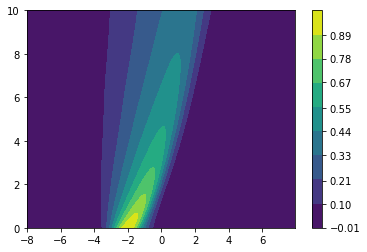

In [50]:
plot_var = full_domain_pred
levels = np.linspace(plot_var.min(), plot_var.max(), 10)
plt.contourf(X, T, plot_var.T, levels)
plt.colorbar(ticks=np.round(levels, 2))
plt.show()

In [51]:
fname2wsindy = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_learnable{with_initial_data}_sim_pinn{n_nodes}_noiselv{noise_lv}_{smoother_name}{n_components}_prediction.h5"
h5file(fname2wsindy, 
      {"usol": full_domain_pred, 
       "avg_final_coeff": avg_final_coeff
      }, mode='w')
fname2wsindy

'../PMS_data/ksvd/filterpy/transform_n_nonzero_coefs_none/burgers_learnable_lm_sim_pinn5_noiselv30_filterpy32_prediction.h5'

In [52]:
# ไม่ใช้แล้ว
# noise30 without RDAE
# Detect when BIC change is relatively small...
# Do not need a high alpha anymore because we regards PINN's interpolation as denoising
# 1e-1: -39424.94355880412 |
# 1e-2: -40494.82294209987 | (0.9883480862923191, 0.9138094915115704)
# 1e-3: -40480.63705933408 | (0.9449528593270584, 0.8633772931360639) ***
# 1e-4: -40480.47898107709 | 
# 1e-5: -40480.47735571946 | 
# 1e-6: -40480.4773739669 | 

# noise30 with RDAE
# 1e-1: -41925.77786014693 | (1.9317244386014787, 1.6329277859100433)
# 1e-2: -44800.92635960881 | (0.6162897470062767, 0.3738864384676466)
# 1e-3: -44811.40529297132 | (0.6665730447923304, 0.4183628350028181)
# 1e-4: -44811.499217262855 | (0.667096965733599, 0.41882922696416247)
# 1e-5: -44811.49996080191 | (0.6671021058580001, 0.41883382329487573)
# 1e-6: -44811.49996448646 | (0.6671021470098404, 0.4188338762355748)

#### Notes
    - 3 main files are required.
#### Ideas
    - Final ans:  Avg X_pre, y_pre (with 10 random seeds) after PINN training, then OLS
    - Final ans from full domain
    - Change ps.FiniteDiff (in weak_pde_lib) to Kalman
    
    - BIC on validation data | full data/domain | calculated after PINN training
    - WSINDy as a (better) final ans? | Read the WSINDy paper
    - Discover PDE's initial condition -> เสริม DeepONet
    - Detect when BIC change is relatively small